In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix   
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense   
import os
import cv2
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

2025-09-04 23:58:24.205555: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757030304.467926      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757030304.555306      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
class_names=['benign', 'malignant', 'normal']
class_names_label={class_name:i for i, class_name in enumerate(class_names)}
num_classes=len(class_names)
IMAGE_SIZE=(256,256)

In [3]:
class_names_label

{'benign': 0, 'malignant': 1, 'normal': 2}

In [4]:

def load_data(dataset_path="/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT"):
    images, masks, labels = [], [], []

    print(f"Loading {dataset_path} ...")

    for folder in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder)
        if not os.path.isdir(folder_path):
            continue

        label = class_names_label[folder]

        for file in tqdm(os.listdir(folder_path)):
            if "_mask" in file.lower():
                continue 

            img_path = os.path.join(folder_path, file)

            mask_name = file.split(".")[0] + "_mask.png"
            mask_path = os.path.join(folder_path, mask_name)

         
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, IMAGE_SIZE)
            img = np.expand_dims(img, axis=-1) 
            img = img / 255.0 

            if os.path.exists(mask_path):
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                mask = cv2.resize(mask, IMAGE_SIZE)
                mask = np.expand_dims(mask, axis=-1)  
                mask = mask / 255.0  
            else:
                mask = np.zeros(IMAGE_SIZE + (1,), dtype=np.float32)

            images.append(img)
            masks.append(mask)
            labels.append(label)

    images = np.array(images, dtype="float32")
    masks = np.array(masks, dtype="float32")
    labels = np.array(labels, dtype="int32")

    print("Dataset loaded:", images.shape, masks.shape, labels.shape)
    return images, masks, labels


In [5]:

images, masks, labels = load_data("/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT")


Loading /kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT ...


100%|██████████| 421/421 [00:05<00:00, 79.82it/s] 


Dataset loaded: (780, 256, 256, 1) (780, 256, 256, 1) (780,)


In [6]:
print("Images shape:", images.shape)  
print("Masks shape:", masks.shape)     
print("Labels shape:", labels.shape)   


Images shape: (780, 256, 256, 1)
Masks shape: (780, 256, 256, 1)
Labels shape: (780,)


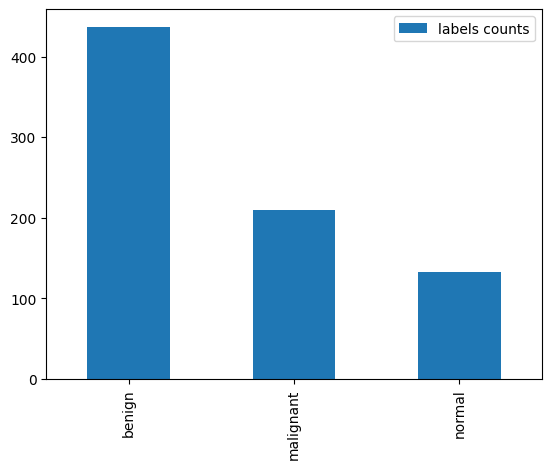

In [7]:
_,counts=np.unique(labels,return_counts=True)
pd.DataFrame({'labels counts':counts},index=class_names).plot.bar()
plt.show()

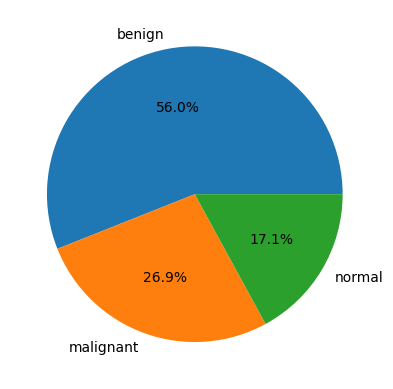

In [8]:
plt.pie(counts,explode=(0, 0, 0),labels=class_names,autopct="%1.1f%%")
plt.show()

## the dataset is skewed toward benign cases.

In [9]:

np.random.seed(42)

indices = np.arange(images.shape[0])
np.random.shuffle(indices)

images = images[indices]
masks = masks[indices]
labels = labels[indices]


In [10]:
from sklearn.model_selection import train_test_split


X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, stratify=labels, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print("Train:", X_train.shape, y_train.shape)
print("Val:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)


Train: (546, 256, 256, 1) (546,)
Val: (117, 256, 256, 1) (117,)
Test: (117, 256, 256, 1) (117,)


In [11]:
def display_random_image(class_names,images,labels):
    index=np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title("Image #{} : ".format(index)+class_names[labels[index]])

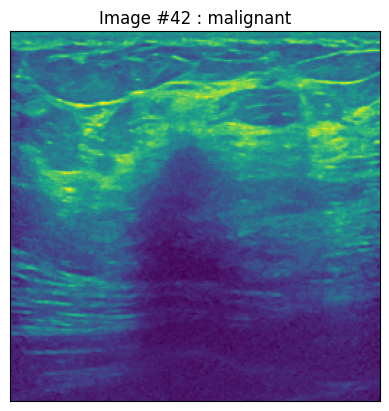

In [12]:
display_random_image(class_names,X_train,y_train)

In [13]:
def display_examples(class_names,images,labels):
    fig = plt.figure(figsize=(10, 10))
    fig.suptitle('Some Example Of The Image From Dataset',fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i],cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

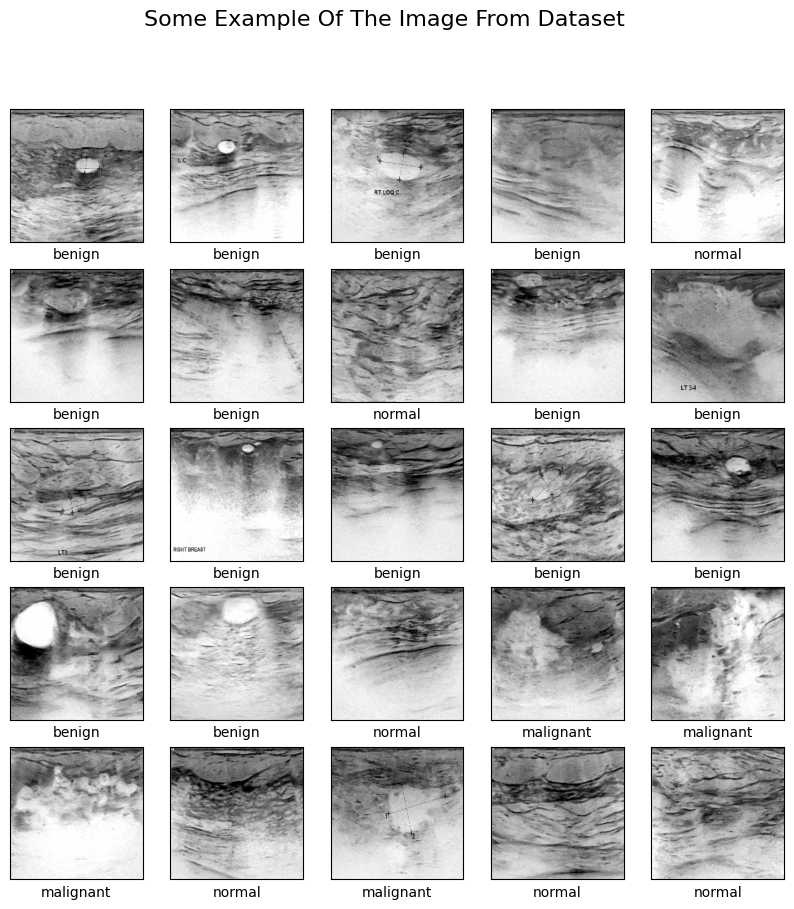

In [14]:
display_examples(class_names,X_train,y_train)

In [15]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)


Class Weights: {0: 0.5947712418300654, 1: 1.2380952380952381, 2: 1.956989247311828}


In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)




In [17]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


In [18]:

X_train_rgb = np.repeat(X_train, 3, axis=-1)
X_val_rgb   = np.repeat(X_val, 3, axis=-1)
X_test_rgb  = np.repeat(X_test, 3, axis=-1)

print(X_train.shape)    
print(X_train_rgb.shape) 


(546, 256, 256, 1)
(546, 256, 256, 3)


In [19]:
train_generator = datagen.flow(X_train_rgb, y_train, batch_size=32)

In [20]:

base_model = DenseNet121(weights="imagenet", include_top=False, input_shape=(256, 256, 3))
base_model.trainable = True  # freeze base initially

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)   
output = Dense(3, activation="softmax")(x)  

model = Model(inputs=base_model.input, outputs=output)


model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",  
    metrics=["accuracy"]
)

model.summary()

I0000 00:00:1757030341.504298      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1757030341.504959      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 64, 64,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 64, 64,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 64, 64,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 64, 64,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 64, 64,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 64, 64,    │     12,288 │ conv2_block2_0_r

 Total params: 7,040,579 (26.86 MB)

 Trainable params: 6,956,931 (26.54 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [21]:
for layer in base_model.layers[-100:]:   
    layer.trainable = True


for layer in base_model.layers[:-100]:
    layer.trainable = False


model.compile(
    optimizer=Adam(learning_rate=1e-5),  
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


history_finetune = model.fit(
    train_generator,
    validation_data=(X_val_rgb, y_val),
    epochs=10,
    class_weight=class_weights
)

Epoch 1/10


I0000 00:00:1757030380.945808      65 service.cc:148] XLA service 0x7ac9d0028e00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757030380.946798      65 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1757030380.946820      65 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1757030384.985187      65 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/18 ━━━━━━━━━━━━━━━━━━━━ 17:16 61s/step - accuracy: 0.3438 - loss: 1.3792

I0000 00:00:1757030407.194682      65 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


18/18 ━━━━━━━━━━━━━━━━━━━━ 109s 3s/step - accuracy: 0.3115 - loss: 1.3695 - val_accuracy: 0.3675 - val_loss: 1.0843
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 389ms/step - accuracy: 0.3359 - loss: 1.2711 - val_accuracy: 0.4530 - val_loss: 1.0155
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 387ms/step - accuracy: 0.4309 - loss: 1.2248 - val_accuracy: 0.5128 - val_loss: 0.9626
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 376ms/step - accuracy: 0.4025 - loss: 1.2194 - val_accuracy: 0.5214 - val_loss: 0.9192
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 407ms/step - accuracy: 0.4613 - loss: 1.1056 - val_accuracy: 0.5299 - val_loss: 0.8773
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 392ms/step - accuracy: 0.4313 - loss: 1.1228 - val_accuracy: 0.5556 - val_loss: 0.8516
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 408ms/step - accuracy: 0.4781 - loss: 1.0273 - val_accuracy: 0.5897 - val_loss: 0.8255
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 390ms/step - accuracy: 0.4822 - loss: 1.0131 - val_accuracy: 0.6068 - val_l

In [22]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(X_train_rgb, y_train, verbose=1)
print(f"✅ Train Accuracy: {test_acc:.4f}")
print(f"✅ Train Loss: {test_loss:.4f}")


18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 400ms/step - accuracy: 0.6806 - loss: 0.7552
✅ Train Accuracy: 0.6740
✅ Train Loss: 0.7531


In [23]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test_rgb, y_test, verbose=1)
print(f"✅ Test Accuracy: {test_acc:.4f}")
print(f"✅ Test Loss: {test_loss:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.7189 - loss: 0.7135
✅ Test Accuracy: 0.7009
✅ Test Loss: 0.7362


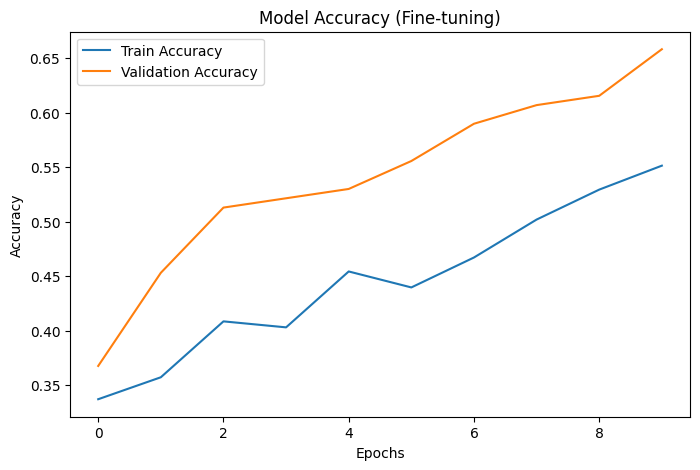

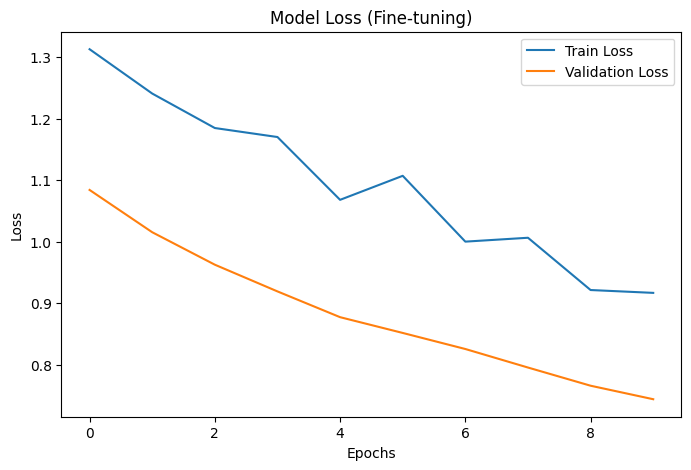

In [24]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(8,5))
plt.plot(history_finetune.history['accuracy'], label='Train Accuracy')
plt.plot(history_finetune.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy (Fine-tuning)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Plot Loss
plt.figure(figsize=(8,5))
plt.plot(history_finetune.history['loss'], label='Train Loss')
plt.plot(history_finetune.history['val_loss'], label='Validation Loss')
plt.title("Model Loss (Fine-tuning)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step


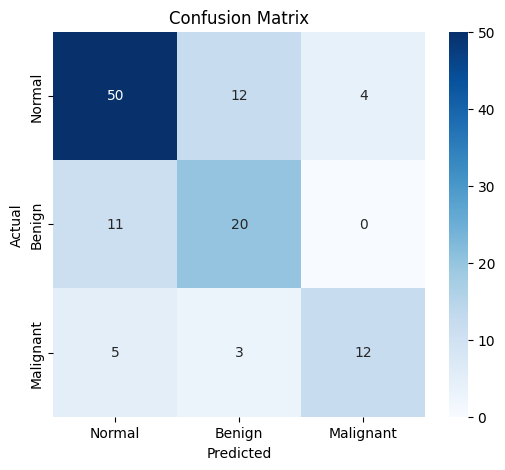

Classification Report:
              precision    recall  f1-score   support

      Normal       0.76      0.76      0.76        66
      Benign       0.57      0.65      0.61        31
   Malignant       0.75      0.60      0.67        20

    accuracy                           0.70       117
   macro avg       0.69      0.67      0.68       117
weighted avg       0.71      0.70      0.70       117



In [25]:
from sklearn.metrics import confusion_matrix, classification_report



y_pred_probs = model.predict(X_test_rgb)             
y_pred = np.argmax(y_pred_probs, axis=1)             


cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Normal", "Benign", "Malignant"], 
            yticklabels=["Normal", "Benign", "Malignant"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Normal", "Benign", "Malignant"]))


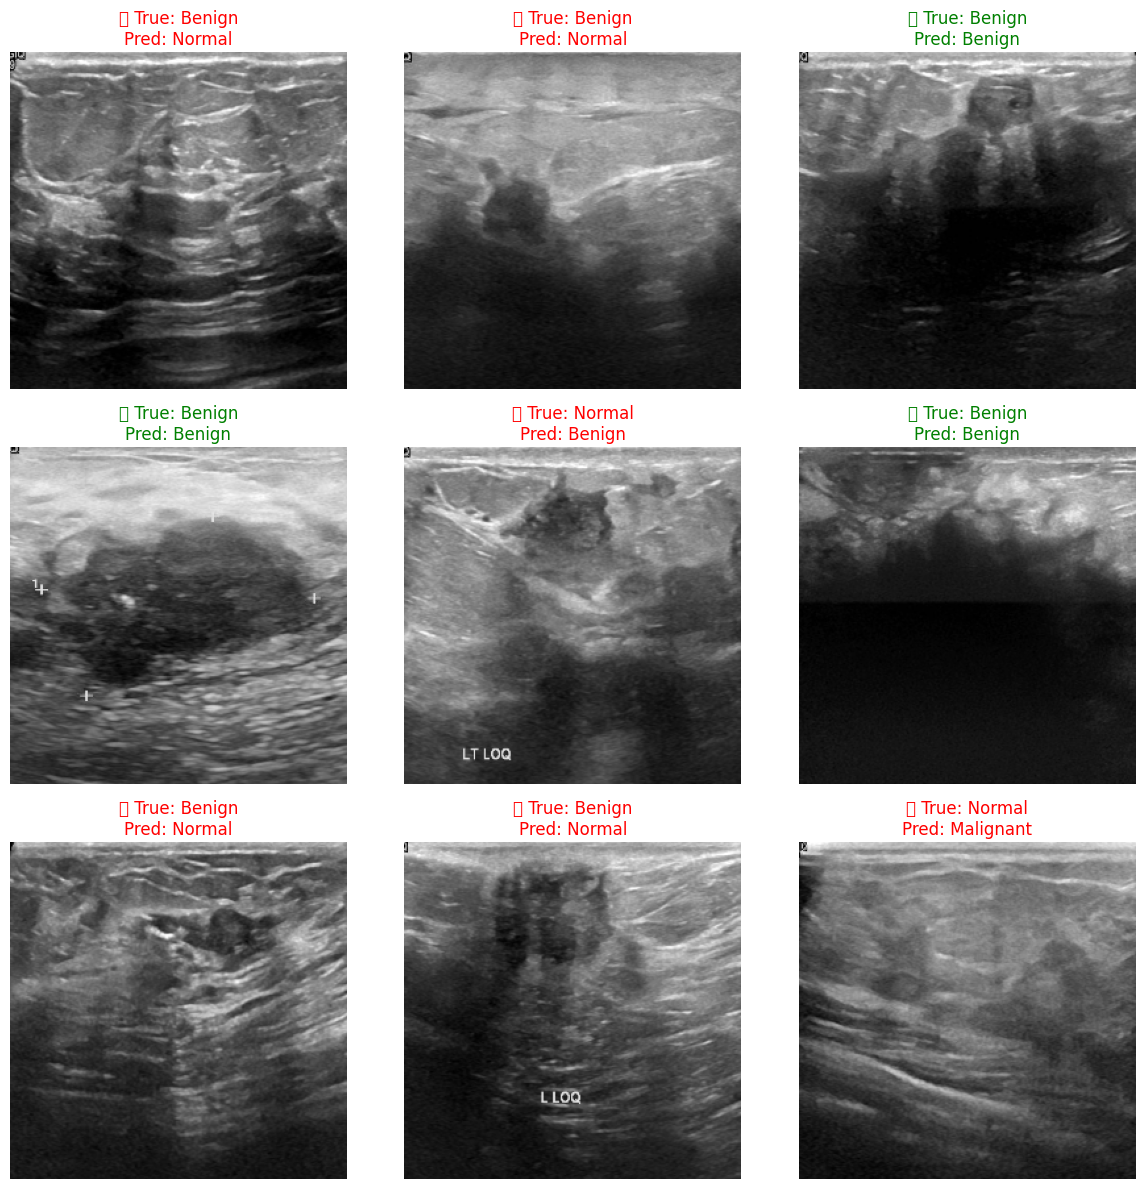

In [26]:
import random
class_names = ["Normal", "Benign", "Malignant"]



indices = random.sample(range(len(X_test_rgb)), 9)

plt.figure(figsize=(12, 12))

for i, idx in enumerate(indices):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_test_rgb[idx])

    true_label = class_names[y_test[idx]]
    pred_label = class_names[y_pred[idx]]
    
    if y_pred[idx] == y_test[idx]:
        color = "green"
        title = f"✅ True: {true_label}\nPred: {pred_label}"
    else:
        color = "red"
        title = f"❌ True: {true_label}\nPred: {pred_label}"
    
    plt.title(title, color=color)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [27]:
import tensorflow as tf
from tensorflow.keras import backend as K

# Clear session
K.clear_session()

# Delete variables
import gc
gc.collect()


0

# Segmentation

In [28]:
IMAGE_SIZE = (256, 256)

def load_data(dataset_path="/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT"):
    images, masks = [], []

    for folder in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder)
        if not os.path.isdir(folder_path):
            continue

        for file in tqdm(os.listdir(folder_path)):
            if "_mask" in file.lower():
                continue

            img_path = os.path.join(folder_path, file)
            mask_name = file.split(".")[0] + "_mask.png"
            mask_path = os.path.join(folder_path, mask_name)

            # Image
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, IMAGE_SIZE)
            img = img[..., np.newaxis] / 255.0

            # Mask
            if os.path.exists(mask_path):
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                mask = cv2.resize(mask, IMAGE_SIZE)
                mask = mask[..., np.newaxis] / 255.0
                mask = (mask > 0).astype(np.float32)
            else:
                mask = np.zeros(IMAGE_SIZE + (1,), dtype=np.float32)

            images.append(img)
            masks.append(mask)

    images = np.array(images, dtype=np.float32)
    masks = np.array(masks, dtype=np.float32)
    print("Dataset loaded:", images.shape, masks.shape)
    return images, masks

images, masks = load_data("/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT")


100%|██████████| 421/421 [00:02<00:00, 187.26it/s]


Dataset loaded: (780, 256, 256, 1) (780, 256, 256, 1)


In [29]:
indices = np.arange(len(images))
np.random.seed(42)
np.random.shuffle(indices)

images = images[indices]
masks = masks[indices]

X_train, X_val, y_train, y_val = train_test_split(
    images, masks, test_size=0.2, random_state=42
)

In [30]:
data_gen_args = dict(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7,1.3]
)
image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)
mask_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)

# Fit generators (required for some transforms)
seed = 42
image_datagen.fit(X_train, augment=True, seed=seed)
mask_datagen.fit(y_train, augment=True, seed=seed)

# Combine generators
train_generator = zip(
    image_datagen.flow(X_train, batch_size=8, seed=seed),
    mask_datagen.flow(y_train, batch_size=8, seed=seed)
)

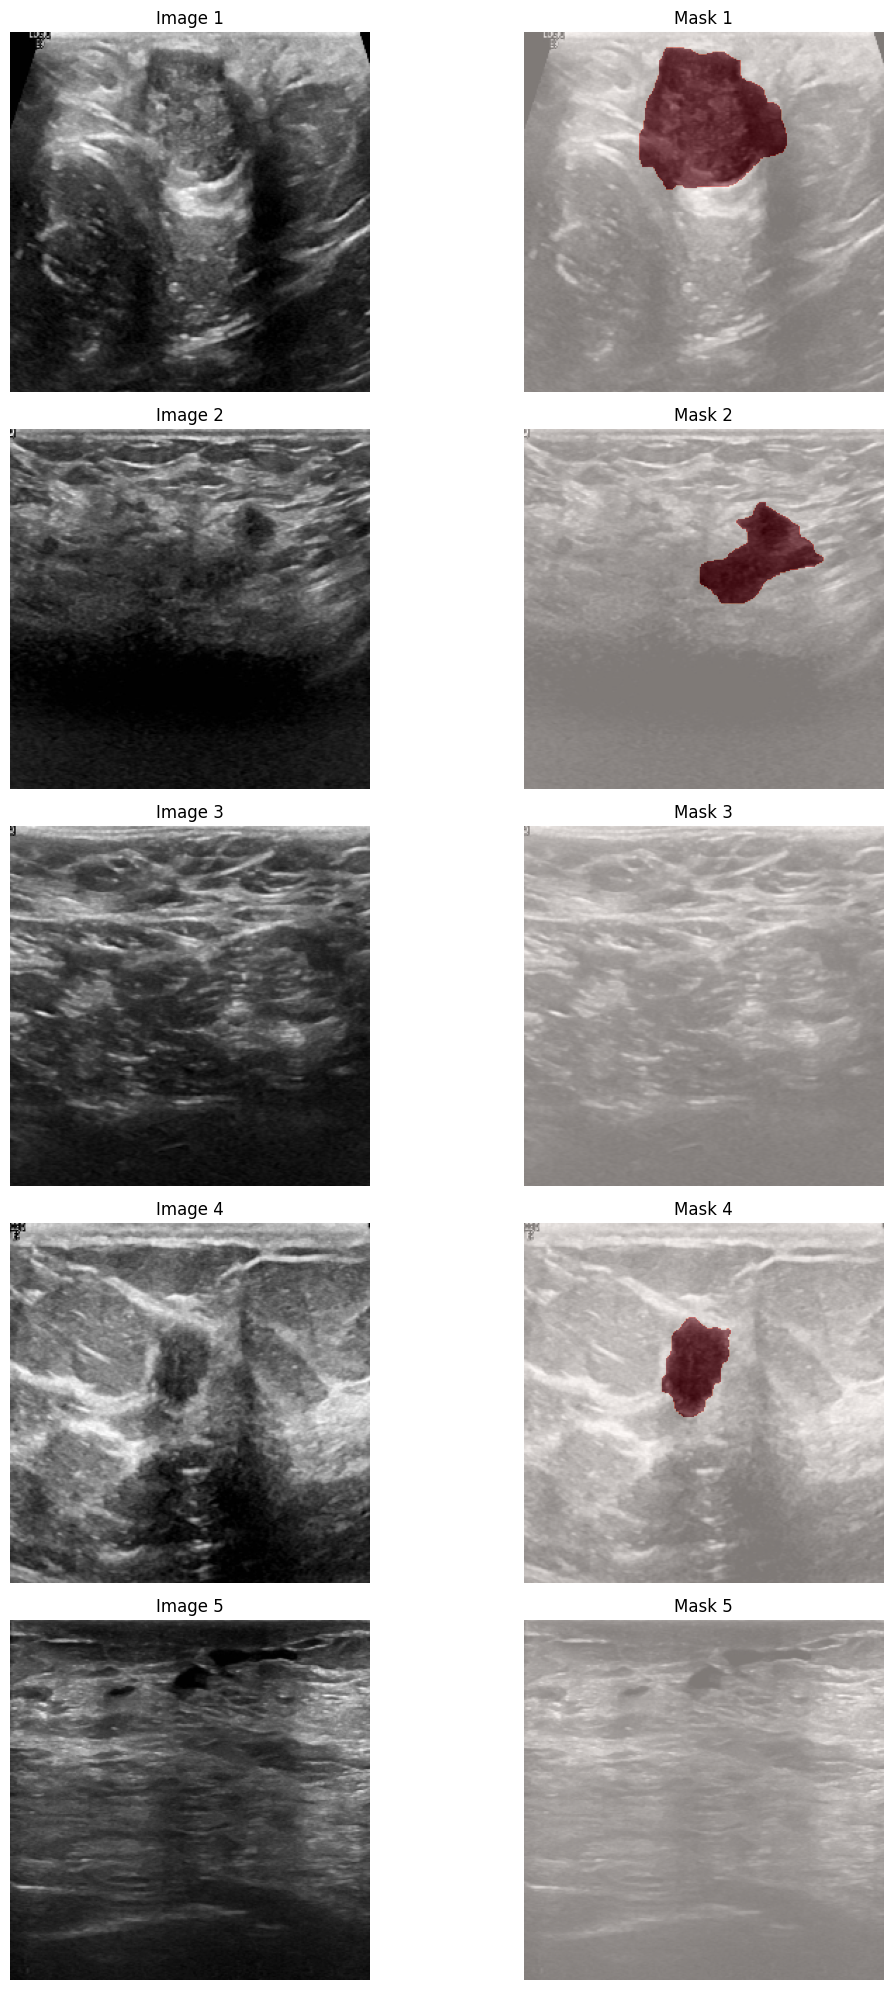

In [31]:

def visualize_samples(images, masks, n=5):
    plt.figure(figsize=(12, n*4))
    
    for i in range(n):
        img = images[i].squeeze()  
        mask = masks[i].squeeze() 

        plt.subplot(n, 2, 2*i+1)
        plt.title(f"Image {i+1}")
        plt.imshow(img, cmap='gray')
        plt.axis('off')

        plt.subplot(n, 2, 2*i+2)
        plt.title(f"Mask {i+1}")
        plt.imshow(img, cmap='gray')
        plt.imshow(mask, cmap='Reds', alpha=0.5)  
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


visualize_samples(images, masks, n=5)


In [32]:

def unet(input_size=(256,256,1)):
    inputs = layers.Input(input_size)
    
    # Encoder
    c1 = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D(2)(c1)
    
    c2 = layers.Conv2D(64, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D(2)(c2)
    
    c3 = layers.Conv2D(128, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(128, 3, activation='relu', padding='same')(c3)
    
    # Decoder
    u1 = layers.UpSampling2D(2)(c3)
    u1 = layers.concatenate([u1, c2])
    c4 = layers.Conv2D(64, 3, activation='relu', padding='same')(u1)
    c4 = layers.Conv2D(64, 3, activation='relu', padding='same')(c4)
    
    u2 = layers.UpSampling2D(2)(c4)
    u2 = layers.concatenate([u2, c1])
    c5 = layers.Conv2D(32, 3, activation='relu', padding='same')(u2)
    c5 = layers.Conv2D(32, 3, activation='relu', padding='same')(c5)
    
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c5)
    
    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model



In [33]:
model = unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 128, 128,  │          0 │ conv2d_5[0][0]    │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128, 128,  │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 192)              │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 128, 128,  │    110,656 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d_6[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 256, 256,  │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 256, 256,  │          0 │ up_sampling2d_1[… │
│ (Concatenate)       │ 96)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 256, 256,  │     27,680 │ concatenate_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 256, 256,  │      9,248 │ conv2d_8[0][0]  

 Total params: 470,977 (1.80 MB)

 Trainable params: 470,977 (1.80 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=8,
    epochs=20
)

Epoch 1/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 31s 181ms/step - accuracy: 0.9214 - loss: 0.3955 - val_accuracy: 0.9239 - val_loss: 0.2600
Epoch 2/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 105ms/step - accuracy: 0.9198 - loss: 0.2635 - val_accuracy: 0.9239 - val_loss: 0.2510
Epoch 3/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 105ms/step - accuracy: 0.9174 - loss: 0.2653 - val_accuracy: 0.9239 - val_loss: 0.2510
Epoch 4/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 106ms/step - accuracy: 0.9165 - loss: 0.2615 - val_accuracy: 0.9239 - val_loss: 0.2462
Epoch 5/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 106ms/step - accuracy: 0.9194 - loss: 0.2562 - val_accuracy: 0.9239 - val_loss: 0.2456
Epoch 6/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 107ms/step - accuracy: 0.9190 - loss: 0.2534 - val_accuracy: 0.9239 - val_loss: 0.2464
Epoch 7/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 107ms/step - accuracy: 0.9253 - loss: 0.2388 - val_accuracy: 0.9239 - val_loss: 0.2469
Epoch 8/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 108ms/step - accuracy: 0.9235 - loss: 0.2415 - val_accuracy: 0

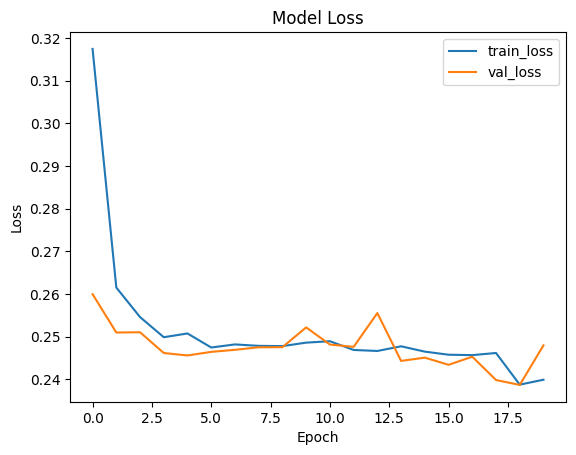

In [35]:
# Plot loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Optional: If you used metrics like Dice or IoU
if 'dice' in history.history:
    plt.plot(history.history['dice'], label='train_dice')
    plt.plot(history.history['val_dice'], label='val_dice')
    plt.title('Dice Score')
    plt.xlabel('Epoch')
    plt.ylabel('Dice')
    plt.legend()
    plt.show()


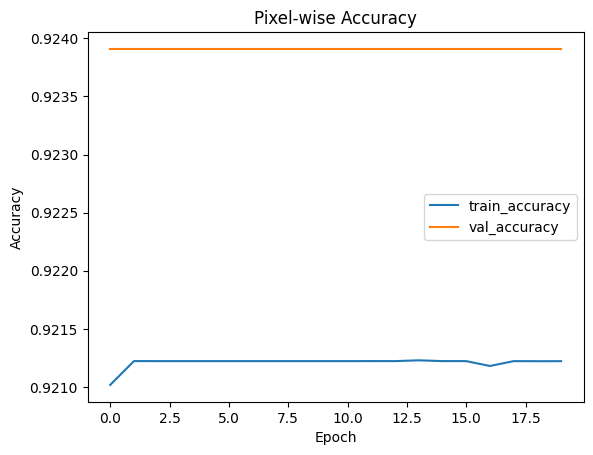

In [36]:

plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Pixel-wise Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [37]:

results_val = model.evaluate(X_val, y_val, batch_size=8)
print("Validation Loss:", results_val[0])
print("Validation Pixel Accuracy:", results_val[1])

results_train = model.evaluate(X_train, y_train, batch_size=8)
print("Training Loss:", results_train[0])
print("Training Pixel Accuracy:", results_train[1])


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9140 - loss: 0.2693
Validation Loss: 0.24796967208385468
Validation Pixel Accuracy: 0.9239086508750916
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9146 - loss: 0.2555
Training Loss: 0.24564148485660553
Training Pixel Accuracy: 0.921221911907196
